In [2]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchtext

# Pre-LN vs. Post-LN Transformer

Learning rate schedule of the original transformer paper

/var/folders/jv/p_nfc0852qv0dsy89d4j7kth0000gn/T/ipykernel_73564/496733851.py:7: RuntimeWarning: divide by zero encountered in divide
  lr = (1/np.sqrt(d)) * np.minimum(1/np.sqrt(step), step * warmup_steps**-1.5)


Text(0, 0.5, 'Learning Rate')

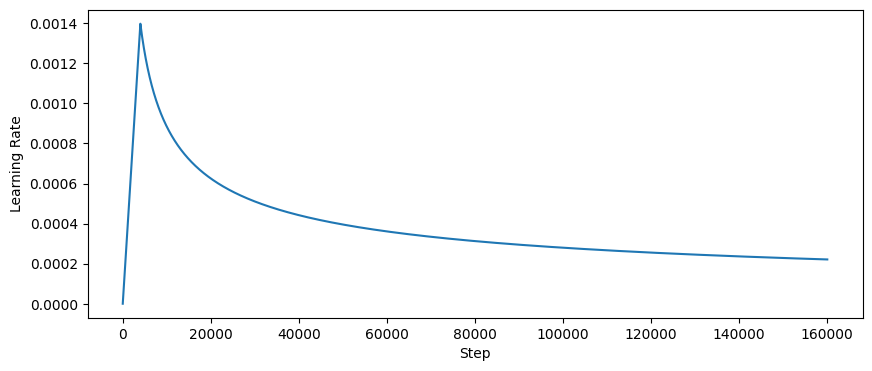

In [348]:
import numpy as np
import matplotlib.pyplot as plt

# learning rate schedule
d = 128 # d_model
step = np.arange(160_000)
warmup_steps = 4000
lr = (1/np.sqrt(d)) * np.minimum(1/np.sqrt(step), step * warmup_steps**-1.5)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(step, lr)
ax.set_xlabel("Step")
ax.set_ylabel("Learning Rate")

In [341]:
import torch
from torch import nn

class PreLNEncoderBlock(nn.Module):
    def __init__(self, embed_dim, ffn_size, num_heads=2, dropout=0.1):
        super(PreLNEncoderBlock, self).__init__()
        self.mhattn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ffn_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ffn_size, embed_dim),
        )
        self.input_ln = nn.LayerNorm(embed_dim)
        self.ffn_ln = nn.LayerNorm(embed_dim)

    def forward(self, x):
        y = self.input_ln(x)
        y, _ = self.mhattn(y, y, y)
        y += x

        z = self.ffn_ln(y)
        z = self.ffn(z)
        z += y

        return z
    
    
class PostLNencoderBlock(nn.Module):
    def __init__(self, embed_dim, ffn_size, num_heads=2, dropout=0.1):
        super(PostLNencoderBlock, self).__init__()
        self.mhattn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ffn_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ffn_size, embed_dim),
        )
        self.input_ln = nn.LayerNorm(embed_dim)
        self.ffn_ln = nn.LayerNorm(embed_dim)

    def forward(self, x):
        y, _ = self.mhattn(x, x, x)
        y += x
        y = self.input_ln(y)
        
        z = self.ffn(y)
        z += y
        z = self.ffn_ln(z)

        return z

In [342]:
preln_block = PreLNEncoderBlock(128, 64)
postln_block = PostLNencoderBlock(128, 64)

x = torch.randn(1, 500, 128)
y_preln = preln_block(x)
y_postln = postln_block(x)

# Layer Normalization

In [331]:
import torch
from torch import nn


class LayerNorm(nn.Module):
    def __init__(self, nchannels, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
        self.gamma = nn.Parameter(torch.ones(nchannels), requires_grad=True)
        self.beta = nn.Parameter(torch.zeros(nchannels), requires_grad=True)
    
    def forward(self, x):
        num = x - x.mean(dim=-1, keepdims=True)
        denom = torch.var(x, dim=-1, keepdims=True)
        denom = torch.sqrt(denom + self.epsilon)
        return num / denom * self.gamma + self.beta


class RMSNorm(nn.Module):
    def __init__(self, nchannels, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
        self.gamma = nn.Parameter(torch.ones(nchannels), requires_grad=True)

    def forward(self, x):
        denom = (x ** 2).mean(dim=-1, keepdims=True)
        denom = torch.sqrt(denom + self.epsilon)
        return x / denom * self.gamma

In [332]:
x = torch.rand(1, 500, 256)
ln = LayerNorm(256)
rmsn = RMSNorm(256)

y_ln = ln(x)
y_rmsn = rmsn(x)

# Positional Encoding and Embedding

## Sinusoidal positional encoding

Text(0, 0.5, 'Depth')

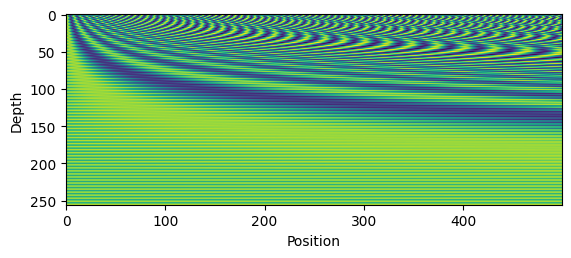

In [318]:
import torch

def sinusoidal_positional_encoding_vaswani(emb_size, seq_len):
    position = torch.arange(seq_len)
    timescales = torch.pow(
        1 / 10000,
        2 * (torch.arange(emb_size) // 2) / emb_size,
    )
    angles = position.unsqueeze(1) * timescales.unsqueeze(0)
    out = torch.zeros((seq_len, emb_size))
    # Interleaving sin and cos along embedding dimension
    out[:, 0::2] = torch.sin(angles[:, 0::2])
    out[:, 1::2] = torch.cos(angles[:, 1::2])
    return out

import matplotlib.pyplot as plt
out = sinusoidal_positional_encoding_vaswani(256, 500)
fig, ax = plt.subplots(1, 1)
ax.imshow(out.T)
ax.set_aspect(0.75)
ax.set_xlabel("Position")
ax.set_ylabel("Depth")

Alternative formulation from tensor2tensor

Text(0, 0.5, 'Depth')

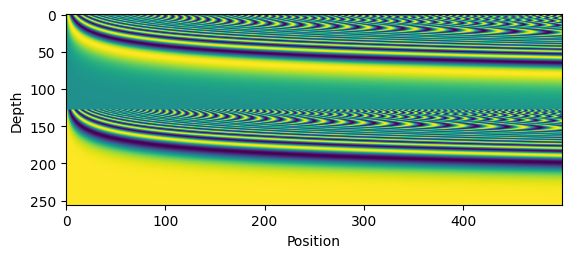

In [319]:
import torch

def sinusoidal_positiona_encoding_tensor2tensor(emb_size, seq_len):
    position = torch.arange(seq_len)
    timescales = torch.pow(
        1 / 10000,
        2 * (torch.arange(emb_size) // 2) / emb_size,
    )
    angles = position.unsqueeze(1) * timescales.unsqueeze(0)
    out = torch.zeros((seq_len, emb_size))
    # Stacking the two partitions
    out = torch.concat([
        torch.sin(angles[:, 0::2]),
        torch.cos(angles[:, 1::2])
    ], axis=1)
    return out


import matplotlib.pyplot as plt
out = sinusoidal_positiona_encoding_tensor2tensor(256, 500)
fig, ax = plt.subplots(1, 1)
ax.imshow(out.T)
ax.set_aspect(0.75)
ax.set_xlabel("Position")
ax.set_ylabel("Depth")

## Positional Embedding

In [ ]:
import torch
from torch import nn

class PositionalEmbedding(nn.Module):
    def __init__(self, seq_len, emb_size):
        super().__init__()
        self.embed = nn.Embedding(seq_len, emb_size)
        
    def forward(self, x):
        # x: (batch_size, seq_len, emb_size)
        pos = torch.arange(x.shape[1], dtype=torch.int32)
        # embedding lookup (batch_size, seq_len, emb_size)
        pos_emb = self.embed(pos)
        # add
        x = x + pos_emb
        
        return x
    
pos_emb = PositionalEmbedding(500, 128)
x = torch.rand(2, 500, 128)
y = pos_emb(x)

## Rotary positional encoding

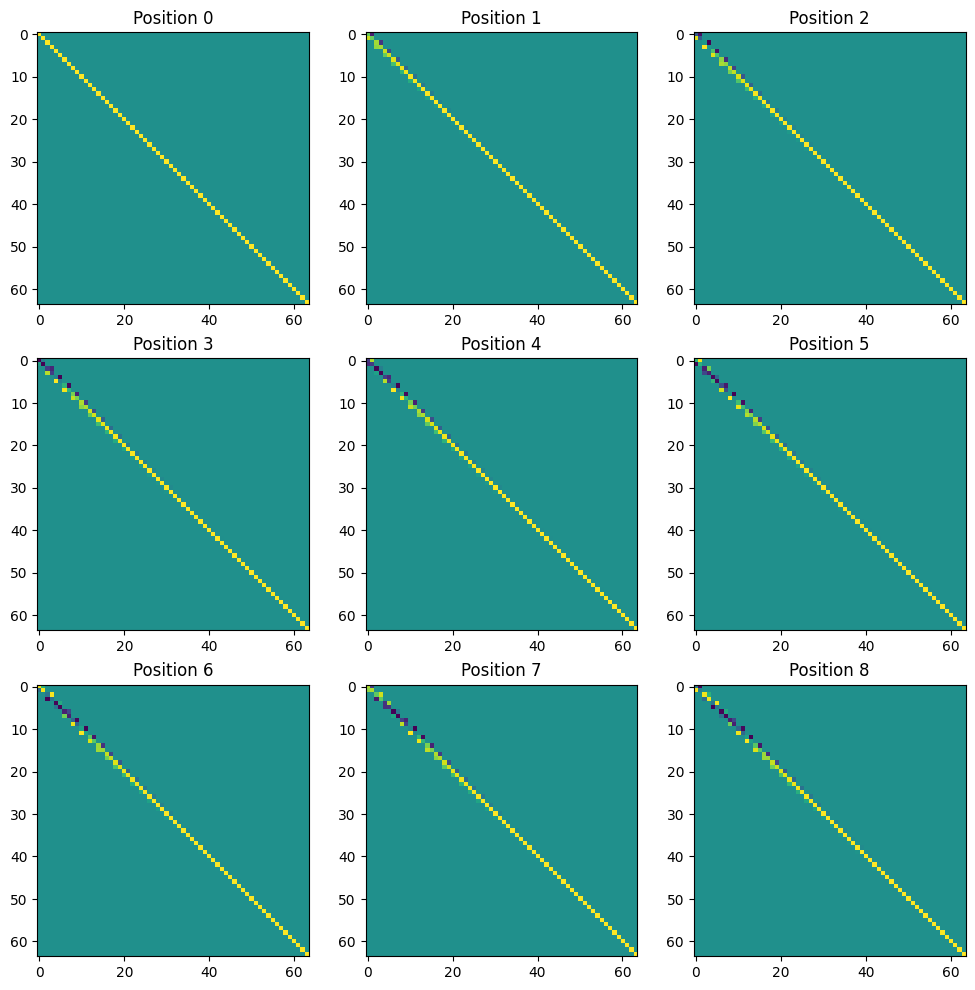

In [320]:
import torch

def rotary_positional_encoding(emb_size, seq_len):
    pos = torch.arange(seq_len).unsqueeze(1)
    depths = torch.arange(emb_size//2).unsqueeze(0)
    theta = 10000**(-2*depths/emb_size)
    p_theta = theta * pos
    # Construct empty R matrix (l, d, d)
    R = torch.zeros(seq_len, emb_size, emb_size)
    # Fill the R matrix
    depths_0 = torch.arange(0, emb_size, 2)
    depths_1 = torch.arange(1, emb_size, 2)
    # Computing rotations
    R[:, depths_0, depths_0] = torch.cos(p_theta)
    R[:, depths_1, depths_1] = R[:, depths_0, depths_0]
    R[:, depths_0, depths_1] = -torch.sin(p_theta)
    R[:, depths_1, depths_0] = -R[:, depths_0, depths_1]
    return R


import matplotlib.pyplot as plt
R = rotary_positional_encoding(64, 500)
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for ii in range(9):
    ax = axs[ii]
    ax.imshow(R[ii, :, :], vmin=-1, vmax=1)
    ax.set_title(f"Position {ii}")


Using complex values to apply rotary positional encoding

In [322]:
import torch

def create_phi(emb_size, seq_len):
    pos = torch.arange(seq_len).unsqueeze(1)
    depths = torch.arange(emb_size//2).unsqueeze(0)
    theta = 10000**(-2*depths/emb_size)
    # (seq_len, emb_size // 2)
    p_theta = theta * pos
    # cos(p_theta) + sin(p_theta) j
    phi = torch.polar(torch.ones_like(p_theta), p_theta)
    return phi

def apply_rotary_position_encoding(phi, x):
    """
    Apply rotary positional encoding
    
    x has (batch_size, seq_len, <num_heads>, emb_size)
    phi has shape (max_seq_len, emb_size)
    """
    # (batch_size, ..., emb_size // 2, 2)
    x = x.reshape(*x.shape[:-1], -1, 2)
    # (batch_size, ..., emb_size // 2), complex
    x = torch.view_as_complex(x) 
    # Slice and reshape phi to match x
    phi = phi[:x.shape[1], :] # same length as x
    broadcast_shape = [
        d if ii == 1 or ii == x.ndim - 1 else 1 
        for ii, d in enumerate(x.shape)
    ]
    phi = phi.view(broadcast_shape)
    # Multiply: (batch_size, ..., emb_size // 2, 2)
    out = torch.view_as_real(x * phi)
    # (batch_size, ..., emb_size)
    out = out.flatten(out.ndim - 2)
    return out
    
phi = create_phi(64, 500)
x = torch.rand(1, 500, 3, 64)

out = apply_rotary_position_encoding(phi, x)

In [369]:
def complex_multiply(a, b):
    a = torch.view_as_real(a) # (..., 2)
    b = torch.view_as_real(b) # (..., 2)
    out_real = a[..., 0] * b[..., 0] - a[..., 1] * b[..., 1]
    out_img  = a[..., 0] * b[..., 1] + a[..., 1] * b[..., 0]
    out = torch.stack([out_real, out_img], axis=-1)
    return out

x = torch.complex(torch.tensor([1, 3, 2, 4]).float(), torch.tensor([5, 3, 8, 7]).float())
y = torch.complex(torch.tensor([5, 2, 1, 3]).float(), torch.tensor([1, 4, 2, 4]).float())
z = x * y
z_mock = complex_multiply(x, y)
z_mock 

tensor([[  0.,  26.],
        [ -6.,  18.],
        [-14.,  12.],
        [-16.,  37.]])

In [368]:
z

tensor([  0.+26.j,  -6.+18.j, -14.+12.j, -16.+37.j])

# Activation Functions in Transformer

In [324]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def relu(x):
    return torch.clamp(x, 0)

def elu(x, alpha=1.0):
    return torch.where(x > 0, x, alpha * torch.exp(x) - 1)

def gelu(x):
    return x * 0.5 * (1 + torch.erf(x / math.sqrt(2.0)))

def mish(x):
    return x * torch.tanh(F.softplus(x))
   
def swish(x, beta=1):
    return x * torch.sigmoid(beta * x)

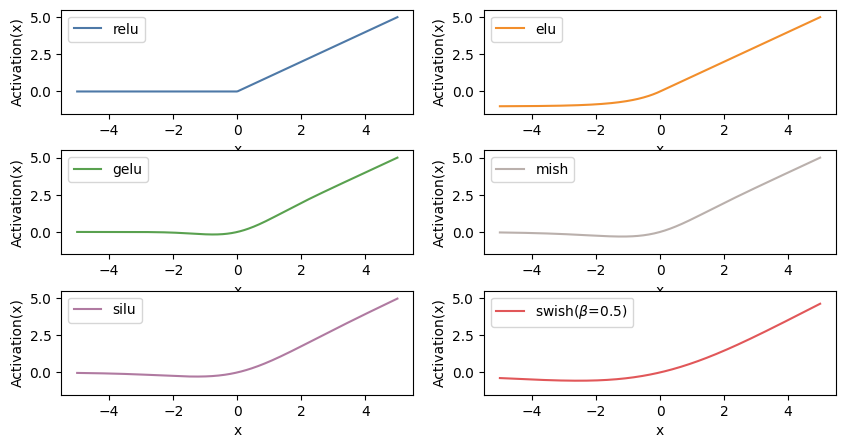

In [330]:
fig, axs = plt.subplots(3, 2, figsize=(10, 5))
x = torch.linspace(-5, 5, 300)
y_relu = relu(x)
y_elu = elu(x, alpha=1.0)
y_gelu = gelu(x)
y_mish = mish(x)
y_silu = swish(x, beta=1.0)
y_swish = swish(x, beta=0.5)

ax = axs[0, 0]
ax.plot(x, y_relu, label="relu", c="#4E79A7")
ax = axs[0, 1]
ax.plot(x, y_elu, label="elu", c="#F28E2B")
ax = axs[1, 0]
ax.plot(x, y_gelu, label="gelu", c="#59A14F")
ax = axs[1, 1]
ax.plot(x, y_mish, label="mish", c="#BAB0AC")
ax = axs[2, 0]
ax.plot(x, y_silu, label="silu", c="#B07AA1")
ax = axs[2, 1]
ax.plot(x, y_swish, label="swish($\\beta$=0.5)", c="#E15759")


for ax in axs.flatten():
    ax.set_xlabel("x")
    ax.set_ylabel("Activation(x)")
    ax.set_ylim(-1.5, 5.5)
    ax.legend()
    
fig.subplots_adjust(hspace=0.35)
fig.savefig("./transformer-activation-functions.svg", dpi=300, bbox_inches="tight")

In [314]:
import torch
from torch import nn
import torch.nn.functional as F


class FFN(nn.Module):
    """
    Original feedforward layer with GeLU activation
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.ffn1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.ffn2 = nn.Linear(hidden_dim, input_dim, bias=False)
        
    def forward(self, x):
        x = self.ffn1(x)
        x = F.gelu(x)
        x = self.ffn2(x)
        return x


class FFNSwiGLU(nn.Module):
    """
    SwiGLU feedforward layer.
    * input_dim: input dimension
    * hidden_dim: hidden dimension
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.linear_gate = nn.Linear(input_dim, hidden_dim, bias=False)
        self.swi_gate = nn.Linear(input_dim, hidden_dim, bias=False)
        self.output = nn.Linear(hidden_dim, input_dim, bias=False)
        
    def forward(self, x):
        linear_term = self.linear_gate(x)
        swi_term = self.swi_gate(x)
        swi_term = F.silu(swi_term)
        return self.output(swi_term * linear_term)

In [317]:
x = torch.randn(1, 500, 128)
ffn_old = FFN(128, 256)
y_old = ffn_old(x)
ffn = FFNSwiGLU(128, 256)
y = ffn(x)

# Case Study: Tiny LLaMA

Let us first implement the model architecture.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import math

class RMSNorm(nn.Module):
    """Root-Mean-Square Layer Normalization."""
    def __init__(self, nchannels, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
        self.gamma = nn.Parameter(torch.ones(nchannels), requires_grad=True)

    def forward(self, x):
        denom = (x ** 2).mean(dim=-1, keepdims=True)
        denom = torch.sqrt(denom + self.epsilon)
        return x / denom * self.gamma


class RotaryPositionalEncoding(nn.Module):
    """Layer to apply rotary positional encoding."""
    def __init__(self, emb_size, seq_len):
        super().__init__()
        phi = self.create_phi(emb_size, seq_len)
        self.phi = nn.Parameter(phi, requires_grad=False)
    
    @staticmethod
    def create_phi(emb_size, seq_len):
        pos = torch.arange(seq_len).unsqueeze(1)
        depths = torch.arange(emb_size//2).unsqueeze(0)
        theta = 10000**(-2*depths/emb_size)
        # (seq_len, emb_size // 2)
        p_theta = theta * pos
        # cos(p_theta) + sin(p_theta) j
        phi = torch.polar(torch.ones_like(p_theta), p_theta)
        return phi
    
    @staticmethod
    def apply_rotary_position_encoding(phi, x):
        """
        Apply rotary positional encoding

        x has (batch_size, seq_len, <num_heads>, emb_size)
        phi has shape (max_seq_len, emb_size)
        """
        # (batch_size, ..., emb_size // 2, 2)
        x = x.reshape(*x.shape[:-1], -1, 2)
        # (batch_size, ..., emb_size // 2), complex
        x = torch.view_as_complex(x) 
        # Slice and reshape phi to match x
        phi = phi[:x.shape[1], :] # same length as x
        broadcast_shape = [
            d if ii == 1 or ii == x.ndim - 1 else 1
            for ii, d in enumerate(x.shape)
        ]
        phi = phi.view(broadcast_shape)
        
        # Multiply: (batch_size, ..., emb_size // 2, 2)
        def complex_multiply_to_real(a, b):
            # Element-wise multiplication of 2 complex numbers
            a = torch.view_as_real(a) # (..., 2)
            b = torch.view_as_real(b) # (..., 2)
            out_real = a[..., 0] * b[..., 0] - a[..., 1] * b[..., 1]
            out_img  = a[..., 0] * b[..., 1] + a[..., 1] * b[..., 0]
            out = torch.stack([out_real, out_img], axis=-1)
            return out
        
        # out = torch.view_as_real(x * phi)
        out = complex_multiply_to_real(x, phi) # MPS device worka
        # (batch_size, ..., emb_size)
        out = out.flatten(out.ndim - 2)
        return out
    
    def forward(self, x):
        return self.apply_rotary_position_encoding(self.phi, x)
    

class FFNSwiGLU(nn.Module):
    """
    SwiGLU feedforward layer.
    * input_dim: input dimension
    * hidden_dim: hidden dimension
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.linear_gate = nn.Linear(input_dim, hidden_dim, bias=False)
        self.swi_gate = nn.Linear(input_dim, hidden_dim, bias=False)
        self.output = nn.Linear(hidden_dim, input_dim, bias=False)
        
    def forward(self, x):
        linear_term = self.linear_gate(x)
        swi_term = self.swi_gate(x)
        swi_term = F.silu(swi_term)
        return self.output(swi_term * linear_term)
    

class RoPEMultiHeadedAttention(nn.Module):
    """RoPE supported multi-headed attention."""
    def __init__(self, emb_dim, num_heads, causal=False):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads
        self.causal = causal
        
        # Layers
        self.rope = RotaryPositionalEncoding(self.head_dim, 1024)
        self.project_q = nn.Linear(emb_dim, emb_dim, bias=False)
        self.project_k = nn.Linear(emb_dim, emb_dim, bias=False)
        self.project_v = nn.Linear(emb_dim, emb_dim, bias=False)
        self.project_o = nn.Linear(emb_dim, emb_dim, bias=False)
    
    def attention(self, query, key, value, mask=None):
        # Apply rotary embeddings
        query = self.rope(query)
        key = self.rope(key)

        # Compute attention score
        scores = torch.matmul(
            query.permute(0, 2, 1, 3), 
            key.permute(0, 2, 3, 1)
        )
        scores = scores / math.sqrt(self.emb_dim)
        
        # Masking
        if mask is not None: 
            # true indicate the entries to keep
            mask = mask.unsqueeze(0).unsqueeze(0)
            scores += (1 - mask) * -1e9
            
        if self.causal:
            causal_mask = torch.triu(torch.ones(scores.shape[-2:]))
            scores += causal_mask.to(scores.device) * -1e9
            
        attn = F.softmax(scores, dim=-1)
        output = torch.matmul(attn, value.permute(0, 2, 1, 3))
        output = output.permute(0, 2, 1, 3)
        
        return output, attn
        
    def forward(self, q, k, v, mask=None):
        # projecting each input
        x_q = self.project_q(q)
        x_k = self.project_k(k)
        x_v = self.project_v(v)
        
        # (batch_size, seq_len, emb_size)
        b, t, d = q.shape
        shape = (b, t, self.num_heads, self.head_dim)
        # reshaping -> 
        # (batch_size, seq_len, num_heads, emb_size // num_heads)
        query = x_q.view(*shape)
        key = x_k.view(*shape)
        value = x_v.view(*shape)

        # Compute attention
        x_attn, attn_weight = self.attention(query, key, value, mask=mask)
        
        # Reshaping back to (batch_size, seq_len, emb_size)
        x_attn = x_attn.reshape(b, t, d)
        
        # Final projection layer
        x_attn = self.project_o(x_attn)
        
        return x_attn, attn_weight
    

class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, ffn_size, num_heads=4, causal=False):
        super().__init__()
        self.mhattn = RoPEMultiHeadedAttention(
            emb_dim=embed_dim,
            num_heads=num_heads,
            causal=causal,
        )
        self.ffn = FFNSwiGLU(embed_dim, ffn_size)
        self.input_ln = RMSNorm(embed_dim)
        self.ffn_ln = RMSNorm(embed_dim)

    def forward(self, x):
        y = self.input_ln(x)
        y, _ = self.mhattn(y, y, y)
        y += x

        z = self.ffn_ln(y)
        z = self.ffn(z)
        z += y

        return z
    
    
class TransformerPlusPlus(nn.Module):
    def __init__(self, n_layers, vocab_size, embed_dim, ffn_size, num_heads):
        super().__init__()
        self.embed = nn.Embedding(vocab_size+1, embed_dim, padding_idx=0)
        self.decoder = nn.ModuleList([
            DecoderBlock(embed_dim, ffn_size, num_heads, causal=True)
            for _ in range(n_layers)
        ])
        self.final_ln = RMSNorm(embed_dim)
        self.output_layer = nn.Linear(embed_dim, vocab_size)
        
    def forward(self, tokens):
        # (batch_size, seq_len, emb_size)
        x = self.embed(tokens)
        # passing through encoder layers
        for dec in self.decoder:
            x = dec(x)
        
        # Final layer normalization
        x = self.final_ln(x)
        
        # output layer
        logits = self.output_layer(x[:, -1, :])
        
        return logits

In [2]:
# Test the implementation
model = TransformerPlusPlus(n_layers=4, vocab_size=10, embed_dim=64, ffn_size=128, num_heads=4)
tokens = torch.tensor(
    [[1, 3, 2, 5, 3, 0, 0, 0],
      [5, 8, 3, 1, 4, 7, 0, 0]]
)
y = model(tokens)
print(y.shape)

torch.Size([2, 10])


In [12]:
# View model architecture
from torchsummary import summary
model = TransformerPlusPlus(
    n_layers=4, vocab_size=vocab_size, embed_dim=256, ffn_size=512, num_heads=4
)
summary(model)

Layer (type:depth-idx)                                  Param #
├─Embedding: 1-1                                        7,813,888
├─ModuleList: 1-2                                       --
|    └─DecoderBlock: 2-1                                --
|    |    └─RoPEMultiHeadedAttention: 3-1               (294,912)
|    |    └─FFNSwiGLU: 3-2                              393,216
|    |    └─RMSNorm: 3-3                                256
|    |    └─RMSNorm: 3-4                                256
|    └─DecoderBlock: 2-2                                --
|    |    └─RoPEMultiHeadedAttention: 3-5               (294,912)
|    |    └─FFNSwiGLU: 3-6                              393,216
|    |    └─RMSNorm: 3-7                                256
|    |    └─RMSNorm: 3-8                                256
|    └─DecoderBlock: 2-3                                --
|    |    └─RoPEMultiHeadedAttention: 3-9               (294,912)
|    |    └─FFNSwiGLU: 3-10                             393,216
|   

Layer (type:depth-idx)                                  Param #
├─Embedding: 1-1                                        7,813,888
├─ModuleList: 1-2                                       --
|    └─DecoderBlock: 2-1                                --
|    |    └─RoPEMultiHeadedAttention: 3-1               (294,912)
|    |    └─FFNSwiGLU: 3-2                              393,216
|    |    └─RMSNorm: 3-3                                256
|    |    └─RMSNorm: 3-4                                256
|    └─DecoderBlock: 2-2                                --
|    |    └─RoPEMultiHeadedAttention: 3-5               (294,912)
|    |    └─FFNSwiGLU: 3-6                              393,216
|    |    └─RMSNorm: 3-7                                256
|    |    └─RMSNorm: 3-8                                256
|    └─DecoderBlock: 2-3                                --
|    |    └─RoPEMultiHeadedAttention: 3-9               (294,912)
|    |    └─FFNSwiGLU: 3-10                             393,216
|   

Prepare data

In [4]:
import numpy as np
# !pip install torchtext==0.16.0 portalocker==2.8.2
# Make sure to restart the python shell after installing portalocker
import torchtext
from torchtext.transforms import BERTTokenizer
from tqdm import tqdm

def sample_sentence(element, max_context_size=64):
    """Take a sentence, and subset the tokens into input and next word."""
    l = len(element)
    start = np.random.randint(0, l-3)
    end = np.random.randint(start, l-1)
    if end - start > max_context_size:
        start = end - max_context_size
    sentence = element[start:end]
    sentence = np.array(sentence).astype(int).tolist()
    next_word = element[end]
    next_word = int(next_word)
    return sentence, next_word

def collate_fn(elements):
    """Collect data into padded batches."""
    sentence, next_word = zip(*elements)
    sentence = torch.nested.nested_tensor(
        list(sentence)).to_padded_tensor(padding=-1)
    sentence = sentence.long() + 1
    next_word = torch.tensor(next_word) + 1 # index offset by 1
    return sentence, next_word


VOCAB_FILE = "https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt"
vocab_size = 30522
tokenizer = BERTTokenizer(
    vocab_path=VOCAB_FILE, do_lower_case=True, return_tokens=False
)
train_dataset = torchtext.datasets.WikiText2(
    "./wikitext2", split="train"
).map(tokenizer).filter(lambda x: len(x) > 5).map(sample_sentence)
eval_dataset = torchtext.datasets.WikiText2(
    "./wikitext2", split="valid"
).map(tokenizer).filter(lambda x: len(x) > 5).map(sample_sentence)

train_data = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, collate_fn=collate_fn
)
eval_data = torch.utils.data.DataLoader(
    eval_dataset, batch_size=32, collate_fn=collate_fn
)

100%|████████████████████████████████████████| 232k/232k [00:00<00:00, 5.11MB/s]


Train the model: Google Colab with GPU is highly recommended to train more epochs.

In [7]:
if torch.cuda.is_available():  # NVIDIA GPU
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # Apple Silicon
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
# prepare model
model = TransformerPlusPlus(
    n_layers=4, vocab_size=vocab_size, embed_dim=256, ffn_size=512, num_heads=4
)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
num_epochs = 10

def train_epoch(model, device, train_data, optimizer):
    model.train()
    loss_train = 0.0
    accuracy_train = 0.0
    n_examples = 0
        
    # iterate over data
    for X, y in tqdm(train_data):
        # Ship data to training device
        X, y = X.to(device), y.to(device)
        n_examples += len(y)
        # Forward pass
        optimizer.zero_grad()
        y_pred = model(X)
        loss = F.cross_entropy(y_pred, y, reduction="sum")
        loss_train += loss # accumulating
        loss = loss / len(y) # average
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        accuracy_train += (y_pred.argmax(dim=1) == y).sum()
        
    # Gather losses
    avg_loss = loss_train / n_examples
    avg_acc = accuracy_train / n_examples
    
    return avg_loss, avg_acc


def eval_epoch(model, device, eval_data):
    loss_eval = 0.0
    accuracy_eval = 0.0
    n_examples = 0
    with torch.no_grad():
        for X, y in tqdm(eval_data):
            X, y = X.to(device), y.to(device)
            n_examples += len(y)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y, reduction="sum")
            loss_eval += loss.item()

            # Compute accuracy
            accuracy_eval += (y_pred.argmax(dim=1) == y).sum()

    # Gather losses
    avg_loss = loss_eval / n_examples
    avg_acc = accuracy_eval / n_examples
    return avg_loss, avg_acc


# train
history = {
    "train_loss": [],
    "train_acc": [],
    "eval_loss": [],
    "eval_acc": [],
}
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, device, train_data, optimizer)
    eval_loss, eval_acc = eval_epoch(model, device, eval_data)
    print(
        f"Epoch {epoch+1}/{num_epochs}:",
        f"train_loss - {train_loss:.2f},",
        f"train_acc - {train_acc:.2f}",
        f"eval_loss - {eval_loss:.2f},",
        f"eval_acc - {eval_acc:.2f}",
    )
    history["train_loss"].append(float(train_loss))
    history["eval_loss"].append(float(eval_loss))
    history["train_acc"].append(float(train_acc))
    history["eval_acc"].append(float(eval_acc))
    # saving checkpoint
    if (epoch + 1) % 20 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': eval_loss,
            }, f"./checkpoints/tiny_llm_checkpoint_{epoch+1:03d}.pt")

# Saving metrics
with open("./training_history.json", "w") as fid:
    json.dump(history, fid)
# Saving the final model
torch.save(model.state_dict(), "./final_model_weights.pt")

681it [00:50, 13.42it/s]
72it [00:02, 32.56it/s]


Epoch 1/10: train_loss - 6.96, train_acc - 0.16 eval_loss - 5.85, eval_acc - 0.25


681it [00:49, 13.68it/s]
72it [00:02, 33.38it/s]


Epoch 2/10: train_loss - 6.46, train_acc - 0.20 eval_loss - 5.83, eval_acc - 0.22


681it [00:51, 13.17it/s]
72it [00:02, 24.44it/s]


Epoch 3/10: train_loss - 6.27, train_acc - 0.21 eval_loss - 5.65, eval_acc - 0.26


681it [00:49, 13.67it/s]
72it [00:02, 27.45it/s]


Epoch 4/10: train_loss - 6.23, train_acc - 0.21 eval_loss - 5.67, eval_acc - 0.25


681it [00:49, 13.62it/s]
72it [00:02, 32.87it/s]


Epoch 5/10: train_loss - 6.18, train_acc - 0.21 eval_loss - 5.73, eval_acc - 0.26


681it [00:50, 13.47it/s]
72it [00:02, 30.11it/s]


Epoch 6/10: train_loss - 6.14, train_acc - 0.21 eval_loss - 5.67, eval_acc - 0.25


681it [00:50, 13.42it/s]
72it [00:02, 31.90it/s]


Epoch 7/10: train_loss - 6.13, train_acc - 0.21 eval_loss - 5.73, eval_acc - 0.24


681it [00:49, 13.64it/s]
72it [00:02, 31.58it/s]


Epoch 8/10: train_loss - 6.03, train_acc - 0.21 eval_loss - 5.40, eval_acc - 0.27


681it [00:50, 13.36it/s]
72it [00:02, 31.20it/s]


Epoch 9/10: train_loss - 6.10, train_acc - 0.21 eval_loss - 5.56, eval_acc - 0.26


681it [00:50, 13.37it/s]
72it [00:02, 31.31it/s]

Epoch 10/10: train_loss - 6.00, train_acc - 0.21 eval_loss - 5.54, eval_acc - 0.26


In [5]:
import torch
checkpoint = torch.load(
    "/Users/edward/Downloads/tiny_llm_checkpoint_040.pt", map_location=torch.device('cpu'))
model = TransformerPlusPlus(n_layers=4, vocab_size=30522, embed_dim=256, ffn_size=512, num_heads=4)

model.load_state_dict(checkpoint['model_state_dict'])

RuntimeError: Error(s) in loading state_dict for TransformerPlusPlus:
	Missing key(s) in state_dict: "decoder.0.mhattn.rope.phi", "decoder.0.mhattn.project_q.weight", "decoder.0.mhattn.project_k.weight", "decoder.0.mhattn.project_v.weight", "decoder.0.mhattn.project_o.weight", "decoder.0.ffn.linear_gate.weight", "decoder.0.ffn.swi_gate.weight", "decoder.0.ffn.output.weight", "decoder.0.input_ln.gamma", "decoder.0.ffn_ln.gamma", "decoder.1.mhattn.rope.phi", "decoder.1.mhattn.project_q.weight", "decoder.1.mhattn.project_k.weight", "decoder.1.mhattn.project_v.weight", "decoder.1.mhattn.project_o.weight", "decoder.1.ffn.linear_gate.weight", "decoder.1.ffn.swi_gate.weight", "decoder.1.ffn.output.weight", "decoder.1.input_ln.gamma", "decoder.1.ffn_ln.gamma", "decoder.2.mhattn.rope.phi", "decoder.2.mhattn.project_q.weight", "decoder.2.mhattn.project_k.weight", "decoder.2.mhattn.project_v.weight", "decoder.2.mhattn.project_o.weight", "decoder.2.ffn.linear_gate.weight", "decoder.2.ffn.swi_gate.weight", "decoder.2.ffn.output.weight", "decoder.2.input_ln.gamma", "decoder.2.ffn_ln.gamma", "decoder.3.mhattn.rope.phi", "decoder.3.mhattn.project_q.weight", "decoder.3.mhattn.project_k.weight", "decoder.3.mhattn.project_v.weight", "decoder.3.mhattn.project_o.weight", "decoder.3.ffn.linear_gate.weight", "decoder.3.ffn.swi_gate.weight", "decoder.3.ffn.output.weight", "decoder.3.input_ln.gamma", "decoder.3.ffn_ln.gamma". 
	Unexpected key(s) in state_dict: "encoder.0.mhattn.rope.phi", "encoder.0.mhattn.project_q.weight", "encoder.0.mhattn.project_k.weight", "encoder.0.mhattn.project_v.weight", "encoder.0.mhattn.project_o.weight", "encoder.0.ffn.linear_gate.weight", "encoder.0.ffn.swi_gate.weight", "encoder.0.ffn.output.weight", "encoder.0.input_ln.gamma", "encoder.0.ffn_ln.gamma", "encoder.1.mhattn.rope.phi", "encoder.1.mhattn.project_q.weight", "encoder.1.mhattn.project_k.weight", "encoder.1.mhattn.project_v.weight", "encoder.1.mhattn.project_o.weight", "encoder.1.ffn.linear_gate.weight", "encoder.1.ffn.swi_gate.weight", "encoder.1.ffn.output.weight", "encoder.1.input_ln.gamma", "encoder.1.ffn_ln.gamma", "encoder.2.mhattn.rope.phi", "encoder.2.mhattn.project_q.weight", "encoder.2.mhattn.project_k.weight", "encoder.2.mhattn.project_v.weight", "encoder.2.mhattn.project_o.weight", "encoder.2.ffn.linear_gate.weight", "encoder.2.ffn.swi_gate.weight", "encoder.2.ffn.output.weight", "encoder.2.input_ln.gamma", "encoder.2.ffn_ln.gamma", "encoder.3.mhattn.rope.phi", "encoder.3.mhattn.project_q.weight", "encoder.3.mhattn.project_k.weight", "encoder.3.mhattn.project_v.weight", "encoder.3.mhattn.project_o.weight", "encoder.3.ffn.linear_gate.weight", "encoder.3.ffn.swi_gate.weight", "encoder.3.ffn.output.weight", "encoder.3.input_ln.gamma", "encoder.3.ffn_ln.gamma". 